# OWCS FaceIT Match Data dataset - Export a Machine Learning Model
In this notebook, we will perform exploratory data analysis (EDA), build a preprocessing pipelines for numerical and categorical features, train and evaluate the model and export the model.

This dataset contains cleaned and aggregated match data from the Overwatch Champions Series (OWCS) played on FaceIT servers across the EMEA and NA regions. The data covers Stages 1–2 and part of Stage 3 (2025), extracted via the official FaceIT API and processed for analytics and machine learning purposes. The dataset is sourced from Kaggle: https://www.kaggle.com/datasets/stlze8/owcs-faceit-match-data-emea-and-na-2025

## Setup

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')

## Basic info and statistics

In [3]:
# Display first few rows to understand the structure
data.head()

,match_id,match_date,round_num,map_name,hero_bans,team,player,Damage Dealt,Damage Mitigated/Eliminations,Environmental Kills/10m,...,Damage Mitigated/10m,Eliminations,Solo Kills/Final Blows Ratio,Final Blows/10m,Healing Done/10m,Role,map_type,region,phase,stage
0,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Xzodyal,7187,71.46,0.0,...,1004.32,13,0.12,8.65,0.00,Damage,Control,EMEA,Round Robin,S1
1,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Ken,6619,100.00,0.0,...,1297.30,12,0.00,5.41,137.30,Damage,Control,EMEA,Round Robin,S1
2,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Eisgnom,10775,212.65,0.0,...,5287.57,23,0.00,6.49,1375.14,Tank,Control,EMEA,Round Robin,S1
3,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Xeriongdh,4575,0.00,0.0,...,0.00,13,0.00,5.41,9901.62,Support,Control,EMEA,Round Robin,S1
4,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Fdgod,4417,75.47,0.0,...,1223.78,15,0.00,3.24,5347.03,Support,Control,EMEA,Round Robin,S1


In [4]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   match_id                                     6110 non-null   str    
 1   match_date                                   6110 non-null   str    
 2   round_num                                    6110 non-null   int64  
 3   map_name                                     6110 non-null   str    
 4   hero_bans                                    6110 non-null   str    
 5   team                                         6110 non-null   str    
 6   player                                       6110 non-null   str    
 7   Damage Dealt                                 6110 non-null   int64  
 8   Damage Mitigated/Eliminations                6110 non-null   float64
 9   Environmental Kills/10m                      6110 non-null   float64
 10  Damage as p

## Exploratory Data Analysis (EDA)

Before we build a predictive model, we’ll explore:
- The target label distribution (`Result`) to see if the dataset is imbalanced.
- Missing values (notably `region`).
- Distributions of core performance metrics.
- Which numeric player stats appear most correlated with winning (as a first-pass signal for feature selection).

 Note: at this stage the dataset is player × map(round) rows. Later we will transform it into matchup rows by aggregating 5 players into a team and taking TeamA − TeamB differentials.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Parse dates once for later chronological splitting
data['match_date'] = pd.to_datetime(data['match_date'], errors='coerce')

# Checks
print('Rows:', len(data))
print('Unique matches (match_id):', data['match_id'].nunique())
print('Unique players:', data['player'].nunique())
print('Null match_date:', data['match_date'].isna().sum())

display(data[['match_id','match_date','round_num','map_type','region','phase','stage']].head())

Rows: 6110
Unique matches (match_id): 171
Unique players: 150
Null match_date: 0


,match_id,match_date,round_num,map_type,region,phase,stage
0,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,1,Control,EMEA,Round Robin,S1
1,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,1,Control,EMEA,Round Robin,S1
2,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,1,Control,EMEA,Round Robin,S1
3,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,1,Control,EMEA,Round Robin,S1
4,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,1,Control,EMEA,Round Robin,S1


### Target distribution (class balance)

`Result` is the binary label (1 = win for the row’s team, 0 = loss). Because we’ll later reshape the data into *two-team matchups*, it’s still useful to inspect balance at the player-row level first.

Result counts:


Result
0    3050
1    3050
2      10
Name: count, dtype: int64


Result proportions:


Result
0    0.499182
1    0.499182
2    0.001637
Name: proportion, dtype: float64

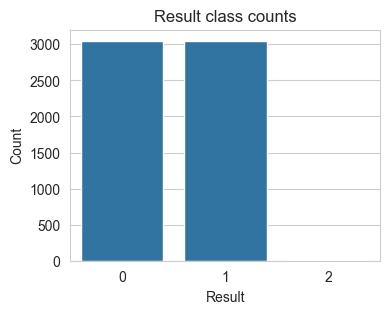

In [22]:
result_counts = data['Result'].value_counts().sort_index()
result_props = data['Result'].value_counts(normalize=True).sort_index()

print('Result counts:')
display(result_counts)
print('\nResult proportions:')
display(result_props)

plt.figure(figsize=(4,3))
sns.barplot(x=result_counts.index.astype(str), y=result_counts.values)
plt.title('Result class counts')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

### Missing values

We’ll check missingness because:
- Missing categorical values (e.g., `region`) need explicit handling (fill + one-hot).
- Missing numeric values (if any) require imputation or row filtering.

Columns with missing values (fraction):


region                 0.486088
Environmental Kills    0.000164
Time Played            0.000164
Objective Time         0.000164
Final Blows            0.000164
Multi Kills            0.000164
Solo Kills             0.000164
dtype: float64

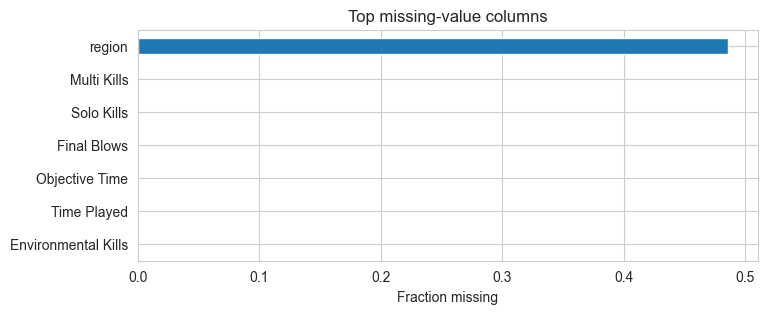

In [23]:
missing = data.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

print('Columns with missing values (fraction):')
display(missing)

plt.figure(figsize=(8,3))
missing.head(15).sort_values().plot(kind='barh')
plt.title('Top missing-value columns')
plt.xlabel('Fraction missing')
plt.show()

### Numeric vs categorical columns

The dataset contains:
- **Metadata / categorical**: e.g. `map_type`, `phase`, `stage`, `Role`, `hero_bans`
- **Numeric player stats**: rates per 10 minutes, ratios, totals

We’ll split these because preprocessing differs (scaling for numeric, one-hot for categorical).

In [24]:
target_col = 'Result'

id_like = {'match_id','match_date','round_num','map_name','hero_bans','team','player'}
cat_like = {'Role','map_type','region','phase','stage'}

categorical_cols = sorted(list((data.columns.intersection(cat_like)).tolist()))

numeric_cols = [c for c in data.columns if c not in id_like and c not in cat_like and c != target_col]

print('Categorical columns:', categorical_cols)
print('Numeric columns:', len(numeric_cols))
print('Example numeric columns:', numeric_cols[:10])

Categorical columns: ['Role', 'map_type', 'phase', 'region', 'stage']
Numeric columns: 43
Example numeric columns: ['Damage Dealt', 'Damage Mitigated/Eliminations', 'Environmental Kills/10m', 'Damage as percent of total output', 'Time Played', 'Solo Kills/Deaths Ratio', 'Healing Done/Eliminations', 'Environmental Kills', 'Damage Mitigated/Deaths', 'Damage Mitigated as percent of total output']


### Distributions of core performance metrics

We’ll look at several high-level gameplay stats that (intuitively) should relate to winning:
- Damage output (`Damage Dealt/10m`)
- Fight impact (`Eliminations/10m`, `Final Blows/10m`)
- Survivability (`Deaths/10m`, `K/D Ratio`)
- Resource contribution (`Healing Done/10m`, `Damage Mitigated/10m`)
- Objective pressure (`Objective Time/10m`)

These are *player-level* distributions; later we’ll aggregate 5 players into team-level sums.

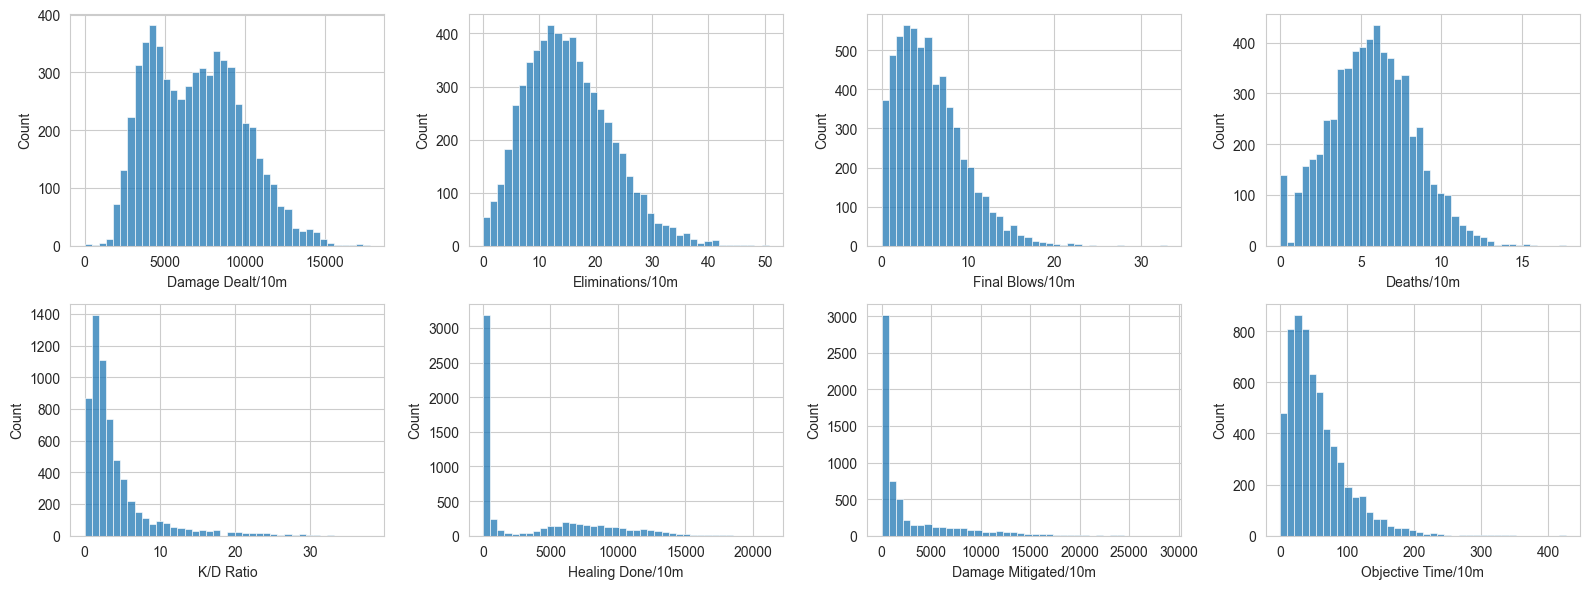

In [27]:
core_stats = [
    'Damage Dealt/10m',
    'Eliminations/10m',
    'Final Blows/10m',
    'Deaths/10m',
    'K/D Ratio',
    'Healing Done/10m',
    'Damage Mitigated/10m',
    'Objective Time/10m',
]

available_core = [c for c in core_stats if c in data.columns]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
axes = axes.ravel()

for ax, col in zip(axes, available_core):
    sns.histplot(data[col].replace([np.inf, -np.inf], np.nan).dropna(), bins=40, kde=False, ax=ax)

for ax in axes[len(available_core):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Correlation with `Result` (player-row level)

Note htat this:
- It’s computed on player rows, not matchups.
- Some columns are mathematically related (ratios derived from other stats).

Still, it helps shortlist candidate stats to aggregate later.

Top 15 absolute correlations with Result (player-row level):


Deaths/10m                              -0.619370
Eliminations/10m                         0.595160
(Eliminations + Assists)/Deaths          0.520242
K/D Ratio                                0.516487
Eliminations                             0.480139
Deaths                                  -0.472157
Final Blows/10m                          0.408164
Damage Dealt/Eliminations               -0.397485
Final Blows                              0.339692
Damage Dealt/(Eliminations + Assists)   -0.330694
Assists/10m                              0.276311
Assists                                  0.232991
Healing Done/Deaths                      0.200796
Solo Kills/Deaths Ratio                  0.198643
Healing Done/Eliminations               -0.191139
Name: Result, dtype: float64

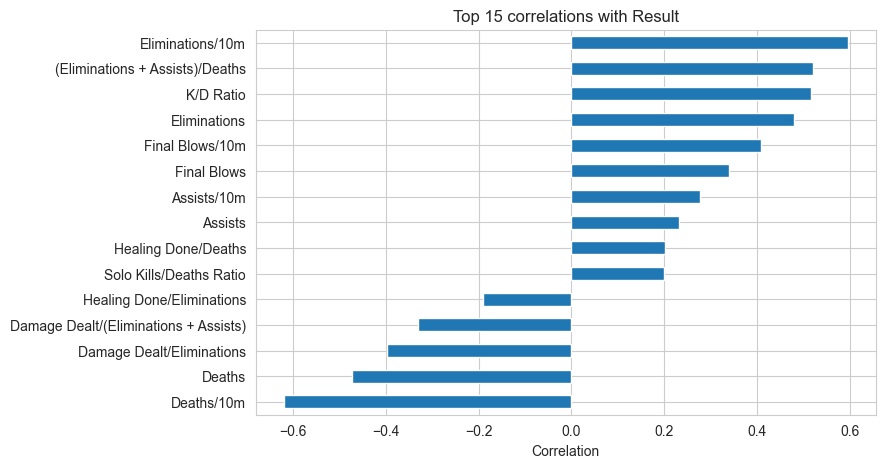

In [26]:
numeric_for_corr = data[numeric_cols + [target_col]].replace([np.inf, -np.inf], np.nan)

corr = numeric_for_corr.corr(numeric_only=True)[target_col].drop(target_col).sort_values(key=lambda s: s.abs(), ascending=False)

topn = 15
print(f'Top {topn} absolute correlations with Result (player-row level):')
display(corr.head(topn))

plt.figure(figsize=(8,5))
corr.head(topn).sort_values().plot(kind='barh')
plt.title(f'Top {topn} correlations with Result')
plt.xlabel('Correlation')
plt.show()

## Selecting Important Features

Based on the EDA above (correlations and domain knowledge about Overwatch), we select per-10-minute rate stats that capture the main dimensions of player performance:

| Group | Columns | Why |
|---|---|---|
| **Damage output** | `Damage Dealt/10m` | Raw firepower per unit time |
| **Eliminations** | `Eliminations/10m`, `Final Blows/10m` | Fight impact and finishing ability |
| **Survivability** | `K/D Ratio`, `Deaths/10m` | Staying alive = more uptime |
| **Healing / support** | `Healing Done/10m` | Sustain provided to teammates |
| **Mitigation / tank** | `Damage Mitigated/10m` | Space creation and damage absorption |
| **Objective pressure** | `Objective Time/10m` | Time spent contesting / pushing |
| **Teamplay** | `Assists/10m` | Enabling teammates to secure kills |

These are all **per-10-minute** rates so they are already time-normalised.  
For each player we first **average** these across all rounds in a match, then **sum** the 5 players per team and take **TeamA − TeamB** differentials as model features.

In [11]:
important_stats = [
    'Damage Dealt/10m',
    'Eliminations/10m',
    'Final Blows/10m',
    'K/D Ratio',
    'Deaths/10m',
    'Healing Done/10m',
    'Damage Mitigated/10m',
    'Objective Time/10m',
    'Assists/10m',
]

print(f'{len(important_stats)} features selected:')
for s in important_stats:
    print(f'  - {s}')

9 features selected:
  - Damage Dealt/10m
  - Eliminations/10m
  - Final Blows/10m
  - K/D Ratio
  - Deaths/10m
  - Healing Done/10m
  - Damage Mitigated/10m
  - Objective Time/10m
  - Assists/10m


## Historical Player Profiles

Since we want to predict matches between arbitrary 5-player teams (players who may never have played together), we build a per-player historical profile.

### Data-Leakage Prevention
During training, the matches in our dataset already happened and their stats are in the data. `shift(1)` ensures we don't use the current match's stats to predict the current match.

### Steps
1. **Average each player's per-10m stats across all rounds within a match:** this gives one row per (player, match) regardless of how many rounds were played (2, 3, 4, etc.).
2. **Compute an expanding mean over each player's match history**: shifted by 1.
3. **Fill NaN:** with global means.

In [12]:
data = data.sort_values(['match_date', 'match_id', 'round_num', 'player']).reset_index(drop=True)

player_match = (
    data
    .groupby(['player', 'match_id', 'match_date', 'team'])[important_stats]
    .mean()
    .reset_index()
    .sort_values(['player', 'match_date', 'match_id'])
)

match_result = (
    data
    .groupby(['match_id', 'team'])['Result']
    .first()
    .reset_index()
)
player_match = player_match.merge(match_result, on=['match_id', 'team'], how='left')

match_meta = (
    data
    .groupby('match_id')[['match_date', 'phase', 'stage']]
    .first()
    .reset_index()
)

hist_cols = [f'{c}_hist' for c in important_stats]

grouped = (
    player_match
    .sort_values(['player', 'match_date', 'match_id'])
    .groupby('player')[important_stats]
    .expanding()
    .mean()
    .groupby(level=0)
    .shift(1)
)
grouped.index = grouped.index.droplevel(0)
grouped.columns = hist_cols

player_match = player_match.join(grouped)

global_means = player_match[hist_cols].mean()
player_match[hist_cols] = player_match[hist_cols].fillna(global_means)

print(f'Player-match rows: {len(player_match)}')
print('Historical columns:', hist_cols)
print('Remaining NaNs in hist cols:', player_match[hist_cols].isna().sum().sum())
player_match[['player', 'match_id'] + hist_cols].head(10)

Player-match rows: 1778
Historical columns: ['Damage Dealt/10m_hist', 'Eliminations/10m_hist', 'Final Blows/10m_hist', 'K/D Ratio_hist', 'Deaths/10m_hist', 'Healing Done/10m_hist', 'Damage Mitigated/10m_hist', 'Objective Time/10m_hist', 'Assists/10m_hist']
Remaining NaNs in hist cols: 0


,player,match_id,Damage Dealt/10m_hist,Eliminations/10m_hist,Final Blows/10m_hist,K/D Ratio_hist,Deaths/10m_hist,Healing Done/10m_hist,Damage Mitigated/10m_hist,Objective Time/10m_hist,Assists/10m_hist
0,Admiral,NA_S1_RR_W1_D1_M2,7007.971713,15.650837,5.771538,4.305641,5.651170,3496.679343,2700.681731,55.246945,7.454487
1,Admiral,NA_S1_RR_W1_D2_M3,4151.567500,7.400000,2.622500,1.062500,7.152500,5954.402500,2818.250000,80.065000,5.982500
2,Admiral,NA_S1_RR_W2_D2_M1,4242.030750,10.249000,2.967250,1.597250,6.673250,6423.319250,2716.009000,83.671500,9.763250
3,Admiral,NA_S1_RR_W3_D1_M1,4450.671611,13.878222,4.169278,2.701500,6.114389,6002.229500,2451.788222,86.894333,12.448833
4,Admiral,NA_S1_RR_W3_D2_M1,4432.187042,13.830333,3.610292,2.790292,5.718292,6282.921292,2572.575333,81.092417,14.910792
5,Admiral,NA_S1_RR_W4_D1_M2,4517.517633,15.349600,3.920900,3.876900,5.392633,6113.237700,2420.049600,75.312600,17.128633
6,Admiral,NA_S1_RR_W4_D3_M1,4425.373028,15.175083,3.934500,3.963667,5.239694,6005.262667,2366.516333,76.626333,17.292611
7,Admiral,NA_S1_PO_UBSF_M2,4357.133310,14.895071,3.607429,3.799571,5.175452,5914.055143,2269.305429,83.081143,17.282952
8,Admiral,NA_S1_PO_LBQF_M2,4352.993208,14.469437,3.613688,3.598063,5.218833,5889.378250,2215.106000,81.344437,16.488208
9,Admiral,NA_S1_PO_LBSF_M1,4374.101000,14.831352,3.616611,3.849389,4.995630,5918.851778,2166.480889,81.425426,17.272111


## Team-Level Feature Engineering

### Approach
1. For each `(match_id, team)` group, sum the historical player stats across 5 players. One row per team per match.
2. Reshape so that each match becomes one row with Team A and Team B columns.
3. Compute differential features: `diff = Team_A_sum − Team_B_sum`.
   - Positive diff → Team A is stronger on that stat; negative → Team B is stronger.
4. Target: `y = 1` if Team A won the overall match, `0` otherwise.


In [13]:
team_agg = (
    player_match
    .groupby(['match_id', 'team'])
    .agg(
        n_players=('player', 'size'),
        Result=('Result', 'first'),
        **{col: (col, 'sum') for col in hist_cols},
    )
    .reset_index()
)

team_agg = team_agg[team_agg['n_players'] == 5]
team_agg = team_agg.merge(match_meta, on='match_id', how='left')
print('Team-level rows (5-player, match-level):', len(team_agg))
team_agg.head()

Team-level rows (5-player, match-level): 272


,match_id,team,n_players,Result,Damage Dealt/10m_hist,Eliminations/10m_hist,Final Blows/10m_hist,K/D Ratio_hist,Deaths/10m_hist,Healing Done/10m_hist,Damage Mitigated/10m_hist,Objective Time/10m_hist,Assists/10m_hist,match_date,phase,stage
0,EMEA_S1_PO_GF_M1,Al qadsiah,5,0,36017.334279,82.172208,29.498321,18.537104,30.325675,19902.302608,17385.026567,296.184687,42.735946,2025-03-09 21:34:47,Playoffs,S1
1,EMEA_S1_PO_GF_M1,Virtuspro,5,1,38437.666426,93.170148,33.888796,26.072074,21.893056,18080.912019,15094.120500,326.794833,47.287926,2025-03-09 21:34:47,Playoffs,S1
2,EMEA_S1_PO_LBF_M1,Al qadsiah,5,1,35688.785291,79.278717,28.798079,18.477053,30.506741,19508.538190,17669.566153,291.615907,40.721611,2025-03-09 19:05:21,Playoffs,S1
3,EMEA_S1_PO_LBQF_M1,Team Peps,5,0,36444.466923,79.000396,28.981470,20.975988,26.684878,18883.631229,15307.605164,285.187732,36.516009,2025-03-02 20:01:00,Playoffs,S1
4,EMEA_S1_PO_LBQF_M2,GenG,5,0,33956.551625,79.828750,28.199833,21.918000,27.244583,15667.459500,13333.776000,287.638354,36.031396,2025-03-02 18:22:54,Playoffs,S1


In [14]:
match_groups = team_agg.groupby('match_id')

rows = []
for mid, grp in match_groups:
    if len(grp) != 2:
        continue
    grp = grp.sort_values('team')
    team_a, team_b = grp.iloc[0], grp.iloc[1]

    result_a = int(team_a['Result'])
    if result_a not in (0, 1):
        continue

    row = {
        'match_id': mid,
        'match_date': team_a['match_date'],
        'phase': team_a['phase'],
        'stage': team_a['stage'],
        'team_a': team_a['team'],
        'team_b': team_b['team'],
    }
    for col in hist_cols:
        row[col + '_diff'] = team_a[col] - team_b[col]
    row['y'] = result_a
    rows.append(row)

matchups = pd.DataFrame(rows)

diff_cols = [c + '_diff' for c in hist_cols]
context_cols = ['phase', 'stage']

matchups = matchups.sort_values(['match_date', 'match_id']).reset_index(drop=True)

print(f'Matchup rows (one per match): {len(matchups)}')
print(f'Differential features: {diff_cols}')
print(f'Context features: {context_cols}')
print(f'Target balance:\n{matchups["y"].value_counts(normalize=True)}')
matchups.head()

Matchup rows (one per match): 109
Differential features: ['Damage Dealt/10m_hist_diff', 'Eliminations/10m_hist_diff', 'Final Blows/10m_hist_diff', 'K/D Ratio_hist_diff', 'Deaths/10m_hist_diff', 'Healing Done/10m_hist_diff', 'Damage Mitigated/10m_hist_diff', 'Objective Time/10m_hist_diff', 'Assists/10m_hist_diff']
Context features: ['phase', 'stage']
Target balance:
y
0    0.513761
1    0.486239
Name: proportion, dtype: float64


,match_id,match_date,phase,stage,team_a,team_b,Damage Dealt/10m_hist_diff,Eliminations/10m_hist_diff,Final Blows/10m_hist_diff,K/D Ratio_hist_diff,Deaths/10m_hist_diff,Healing Done/10m_hist_diff,Damage Mitigated/10m_hist_diff,Objective Time/10m_hist_diff,Assists/10m_hist_diff,y
0,EMEA_S1_RR_W1_D1_M1,2025-01-31 19:17:07,Round Robin,S1,GenG,Virtuspro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,NA_S1_RR_W1_D1_M1,2025-01-31 23:22:34,Round Robin,S1,Team Liquid,Timeless,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,NA_S1_RR_W1_D1_M2,2025-02-01 00:54:46,Round Robin,S1,NTMR,SpaceStation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,EMEA_S1_RR_W1_D2_M2,2025-02-01 20:59:10,Round Robin,S1,GenG,Twisted Minds,-6124.283567,-27.949186,-10.080189,-12.870703,7.646648,-4633.836714,-4052.633653,12.112777,-19.229933,1
4,NA_S1_RR_W1_D2_M1,2025-02-01 22:39:06,Round Robin,S1,Amplify,Avidity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


## Chronological Train / Test Split

Because this is temporal data, we want to predict future matches using past information. A random train/test split would leak future information into training.

Instead we use a chronological cutoff: the earliest 80% of matchup rows become the training set, the latest 20% become the test set. This mirrors the real-world scenario where the model has only seen past results at prediction time.

In [15]:
feature_cols = diff_cols + context_cols

X = matchups[feature_cols]
y = matchups['y']

split_idx = int(len(matchups) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Train size: {len(X_train)}  |  Test size: {len(X_test)}')
print(f'Train y balance: {y_train.value_counts(normalize=True).to_dict()}')
print(f'Test  y balance: {y_test.value_counts(normalize=True).to_dict()}')

Train size: 87  |  Test size: 22
Train y balance: {0: 0.5287356321839081, 1: 0.47126436781609193}
Test  y balance: {1: 0.5454545454545454, 0: 0.45454545454545453}


## Preprocessing Pipeline & Model

We use `make_pipeline` from scikit-learn to bundle preprocessing + classification into a single object.

### Preprocessing
- **Numeric (differential) columns:** `StandardScaler` so all features are on the same scale and regularisation in logistic regression treats them equally.
- **Categorical context columns:** `OneHotEncoder` to convert string categories into binary indicators. (`map_type` is excluded because a single match can span multiple maps.)

A `ColumnTransformer` applies the right transform to the right columns.

### Classifier
- **`LogisticRegression`:** It is a technique that produces well-calibrated probabilities and exports cleanly to ONNX.

### Metric
- **ROC-AUC:** the primary metric. It measures how well the model ranks "Team A wins" vs "Team A loses", regardless of any particular probability threshold. This is ideal because:
  - The classes are roughly balanced (50/50 by construction of the differential).

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), diff_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), context_cols),
    ]
)

pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=42))

pipeline.fit(X_train, y_train)
print('Pipeline fitted successfully.')
print(pipeline)

Pipeline fitted successfully.
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Damage Dealt/10m_hist_diff',
                                                   'Eliminations/10m_hist_diff',
                                                   'Final Blows/10m_hist_diff',
                                                   'K/D Ratio_hist_diff',
                                                   'Deaths/10m_hist_diff',
                                                   'Healing Done/10m_hist_diff',
                                                   'Damage '
                                                   'Mitigated/10m_hist_diff',
                                                   'Objective '
                                                   'Time/10m_hist_diff',
                                                   'Assists/10m_hist_diff']),
                               

## Model Evaluation

We evaluate the trained pipeline on the chronological test set using:
- **ROC-AUC:** ranking quality of predicted probabilities.
- **Accuracy:** fraction of correct hard predictions.
- **Log-loss:** penalises overconfident wrong predictions.
- **Confusion matrix:**  shows true/false positives and negatives.
- **Classification report:** precision, recall, F1 per class.

ROC-AUC : 0.9333
Accuracy: 0.8636
Log-loss: 0.4069

Classification Report:
              precision    recall  f1-score   support

 Team B wins       0.82      0.90      0.86        10
 Team A wins       0.91      0.83      0.87        12

    accuracy                           0.86        22
   macro avg       0.86      0.87      0.86        22
weighted avg       0.87      0.86      0.86        22



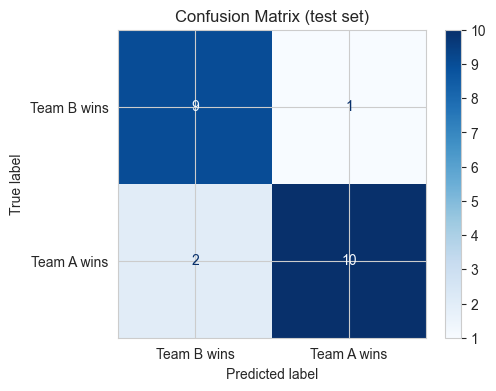

In [17]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, log_loss,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_proba)

print(f'ROC-AUC : {auc:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Log-loss: {ll:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Team B wins', 'Team A wins']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Team B wins', 'Team A wins'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix (test set)')
plt.show()

### Feature Interpretation (Logistic Regression Coefficients)

The logistic regression coefficients tell us how each feature shifts the log-odds of Team A winning when it increases by one standard deviation.

- **Positive coefficient**  higher differential on that stat favours Team A.
- **Negative coefficient**  higher differential on that stat actually correlates with losing (could indicate a stat like `Deaths/10m` where more is worse).

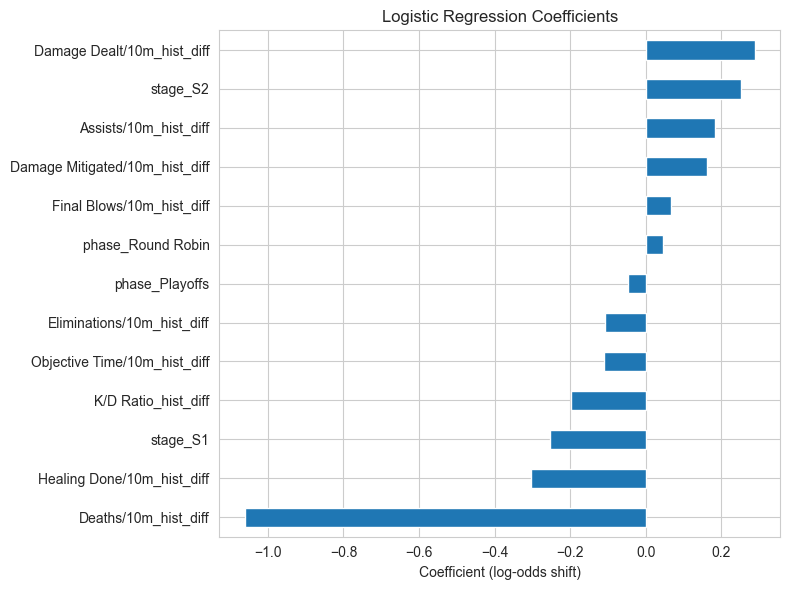

In [18]:
lr = pipeline.named_steps['logisticregression']

ohe = pipeline.named_steps['columntransformer'].named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(context_cols))
all_feature_names = diff_cols + cat_feature_names

coefs = pd.Series(lr.coef_[0], index=all_feature_names).sort_values()

plt.figure(figsize=(8, 6))
coefs.plot(kind='barh')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient (log-odds shift)')
plt.tight_layout()
plt.show()

## Export the Model to ONNX

ONNX (Open Neural Network Exchange) is a framework-agnostic model format supported by many inference runtimes. Exporting our scikit-learn pipeline to ONNX means we can deploy it without needing Python in production.

We use `skl2onnx` to convert the full `Pipeline` (preprocessing + logistic regression) into a single `.onnx` file

In [19]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType

initial_types = (
    [(col, FloatTensorType([None, 1])) for col in diff_cols] +
    [(col, StringTensorType([None, 1])) for col in context_cols]
)

# Disable zipmap so the probabilities como as a tensor and we can use it on node
options = {id(pipeline): {"zipmap": False}}

onnx_model = convert_sklearn(pipeline, initial_types=initial_types, target_opset=15, options=options)

onnx_path = 'match_prediction_model.onnx'
with open(onnx_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())

print(f'ONNX model saved to {onnx_path}')

ONNX model saved to match_prediction_model.onnx


### Verify ONNX model with ONNX Runtime

As a sanity check, we load the exported `.onnx` file via `onnxruntime` and compare its predictions to the scikit-learn pipeline to confirm they match.

In [20]:
import onnxruntime as rt

sess = rt.InferenceSession(onnx_path)

onnx_inputs = sess.get_inputs()
onnx_input_names = [inp.name for inp in onnx_inputs]
print('ONNX input names:', onnx_input_names[:10], '...')

all_original_cols = diff_cols + context_cols
name_map = dict(zip(onnx_input_names, all_original_cols))

sample = X_test.iloc[:10]
feed = {}
for onnx_name in onnx_input_names:
    original_col = name_map[onnx_name]
    if original_col in diff_cols:
        feed[onnx_name] = sample[[original_col]].values.astype(np.float32)
    else:
        feed[onnx_name] = sample[[original_col]].values

onnx_preds = sess.run(None, feed)

sk_preds = pipeline.predict(sample)
sk_proba = pipeline.predict_proba(sample)[:, 1]

print('\nScikit-learn predictions:', sk_preds)
print('ONNX predictions:       ', onnx_preds[0])
print('\nScikit-learn probas:    ', sk_proba.round(4))
onnx_proba_vals = [d[1] for d in onnx_preds[1]]
print('ONNX probas:            ', [round(p, 4) for p in onnx_proba_vals])

ONNX input names: ['Damage_Dealt_10m_hist_diff', 'Eliminations_10m_hist_diff', 'Final_Blows_10m_hist_diff', 'K_D_Ratio_hist_diff', 'Deaths_10m_hist_diff', 'Healing_Done_10m_hist_diff', 'Damage_Mitigated_10m_hist_diff', 'Objective_Time_10m_hist_diff', 'Assists_10m_hist_diff', 'phase'] ...

Scikit-learn predictions: [0 1 0 1 0 1 0 1 1 0]
ONNX predictions:        [0 1 0 1 0 1 0 1 1 0]

Scikit-learn probas:     [0.4812 0.6787 0.1185 0.9108 0.3141 0.5363 0.4881 0.7668 0.5342 0.4695]
ONNX probas:             [np.float32(0.4812), np.float32(0.6787), np.float32(0.1185), np.float32(0.9108), np.float32(0.3141), np.float32(0.5363), np.float32(0.4881), np.float32(0.7668), np.float32(0.5342), np.float32(0.4695)]
